## 6 - Raster
>A map using raster data. Rasters are everywhere, but today’s focus is purely on grids and pixels—satellite imagery, heatmaps, or any continuous surface data. 🟦🟧

In [ ]:
!wget --mirror --no-parent -r -P https://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/indexes/ArcticDEM_Mosaic_Index_latest_gpqt.zip

In [1]:
import cartopy.crs as ccrs
import rioxarray as rio
import matplotlib.pyplot as plt
# from riverrem.REMMaker import REMMaker
import geopandas as gpd
from shapely import Polygon, segmentize
import numpy as np
import xarray as xr
from matplotlib.colors import LogNorm
from matplotlib import font_manager
import osmnx as ox
import mapping_funcs as mf

from shapely import box
from scipy.spatial import KDTree # For Inverse Distance Weight calculation
import matplotlib.patheffects as path_effects
import xrspatial as xrs

In [2]:
font_path = '../../../../../fonts/magenta-flow-font/MagentaFlowRegular-95WZ.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.family'] = prop.get_name()

In [3]:
def make_rem(dem, gdf, k=7, segment=False):
    
    xs, ys = [], []
    for row in gdf.itertuples():
        
        ## add logic here to support polygon exteriors, and multipart geometries
        
        if segment:
            segmented = segmentize(row.geometry, segment)
            _x, _y = segmented.xy
        else:
            _x, _y = row.geometry.xy
        
        xs += _x.tolist()
        ys += _y.tolist()
        
    sampled = dem.interp(x=xr.DataArray(xs, dims='z'),
                         y=xr.DataArray(ys, dims='z')).dropna(dim='z')
    
    path_coords = np.vstack([sampled.coords[c].values for c in ('x', 'y')]).T
    path_values = sampled.data.flatten()
    
    gx, gy = np.meshgrid(dem.x, dem.y)
    grid_coords = np.c_[gx.flat, gy.flat]
    
    # make tree
    tree = KDTree(path_coords)
    
    # idw
    distances, indices = tree.query(grid_coords, k=k)
    weights = 1/ distances
    weights = weights / weights.sum(axis=1).reshape(-1, 1)
    idw_values = (weights * path_values[indices]).sum(axis=1)
    
    # assemble back into dataarray
    idw_ds = xr.DataArray(idw_values.reshape(gx.shape),
                          dims=('y', 'x'),
                          coords={'y':dem.y, 'x': dem.x})
    
    return dem - idw_ds

In [4]:
prj = ccrs.Stereographic(central_latitude=90, central_longitude=-45, true_scale_latitude=70)

# mackenzie river
aoi = Polygon([
            [-134.2894675449453, 68.47113685531792],
            [-134.28197062915962, 68.53240413110609],
            [-134.52262162588346, 68.54776352096403],
            [-134.54886083113354, 68.49780718751387],
            [-134.2894675449453, 68.47113685531792]]
              )

aoi_rprj = mf.Utils.shapely_reprojector(aoi, 4326, 3413)

# get river from polygon
river = (ox.features_from_polygon(aoi,
                                  tags={'waterway':'river'})
         .loc['way']
         .to_crs(3413))

In [5]:
catalog = gpd.read_parquet('ArcticDEM_Mosaic_Index_v4_1_gpqt/ArcticDEM_Mosaic_Index_v4_1_2m.parquet')

# find tile that contains aoi
# if tile doesn't completely contain throw an assertion error
tile = catalog.loc[catalog.geometry.contains(aoi_rprj)]
assert len(tile) == 1, 'too many or too few dem tiles found'
tile = tile.iloc[0]
tile['downloadurl'] = tile.s3url.replace('polargeospatialcenter.github.io/stac-browser/#/external/', "").replace('.json', '_dem.tif')
# lazily open dem

with rio.open_rasterio(tile.downloadurl, chunks='auto') as dem_tile:
    dem = dem_tile.rio.clip_box(*aoi_rprj.bounds).squeeze().compute()
    # coarse = dem.coarsen({'x':10, 'y':10}, boundary='trim').mean()
    # coarse = coarse.compute()
hs = xrs.hillshade(dem, angle_altitude=5)

c:\Users\s1759665\AppData\Local\miniforge-pypy3\envs\mapping\Lib\site-packages\rioxarray\_io.py:935: DeprecationWarning: Supplying chunks as dimension-order tuples is deprecated. It will raise an error in the future. Instead use a dict with dimension names as keys.
  return result.chunk(chunks, name_prefix=name_prefix, token=token)


In [6]:
rem = make_rem(dem, river, k=7, segment=25)
rem_clean = xr.where(rem<0, 0, rem) + 1

Text(0.01, 0.01, 'by:tlohde\nArcticDEM Porter et al.; OpenStreetMap contributors; Chequered Ink')

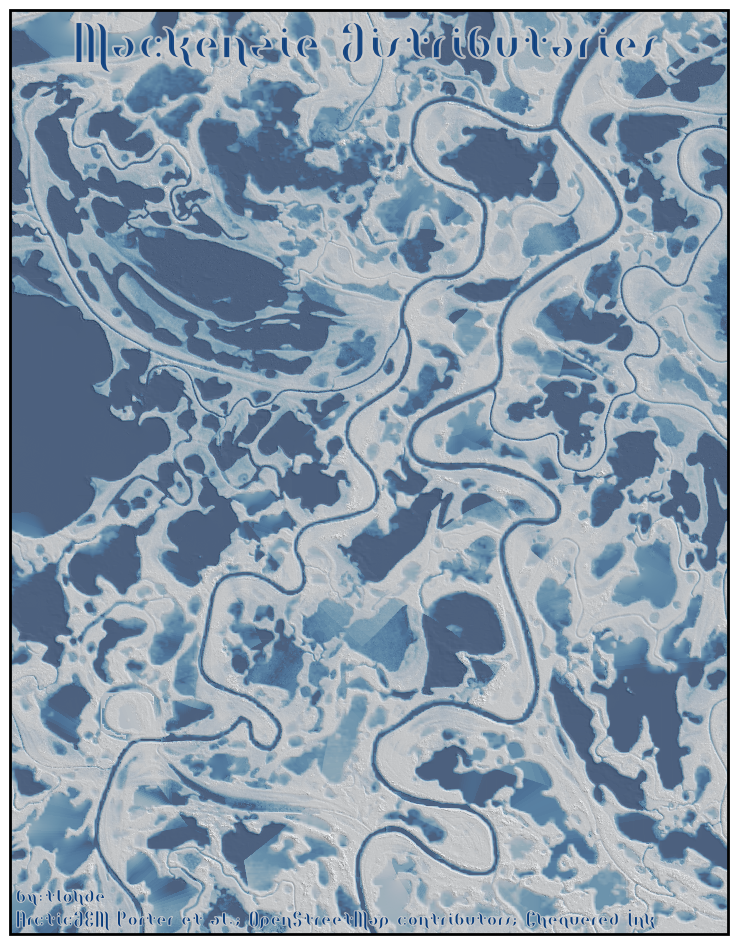

In [8]:
fig, ax = plt.subplots(figsize=[12,12], subplot_kw={'projection':prj})

rem_clean.plot(ax=ax , cmap='Blues_r', norm=LogNorm(1, 6), add_colorbar=False)
hs.plot(cmap='Grays', add_colorbar=False, alpha=0.5)

ax.set(xticks=[],
       yticks=[],
       xlabel=None,
       ylabel=None)

ax.spines[:].set_linewidth(2)

ax.set_title('Mackenzie Distributaries', y=0.94, #x=0.02,
             alpha=0.9,
             path_effects=[path_effects.Stroke(linewidth=3, foreground=(0.8, 0.8, 0.8), alpha=0.8),
                           path_effects.Normal()],
             color=plt.get_cmap('Blues')(0.95),
            #  ha='left',
            #  font='DejaVu Sans Mono',
             fontsize=28)

# attribution
ax.annotate('by:tlohde\nArcticDEM Porter et al.; OpenStreetMap contributors; Chequered Ink',
            xy=(0.01,0.01),
            xycoords='axes fraction',
            color=plt.get_cmap('Blues')(0.95),
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground=(0.8, 0.8, 0.8), alpha=0.8),
                          path_effects.Normal()],
            fontsize=11)

# fig.savefig('day6.png', bbox_inches='tight', dpi=300)

## distance from tube

In [ ]:
import osmnx as ox
from shapely import Polygon, points, MultiPoint
import shapely
from scipy.spatial import KDTree
import numpy as np
import rioxarray as rio
import cmcrameri.cm as cmc
import matplotlib.patheffects as path_effects
from matplotlib_scalebar.scalebar import ScaleBar
from shapely import LineString

In [ ]:
# helpers
def text_along_path(text, curve, ax, **kwargs):
    '''
    plots `text` along the `curve` on axes (`ax`)
    `kwargs` passed to `ax.text()`
    
    curve is array of shape (n,2)
    doesn't do any checks.
    requires some fanangling to get spacing right
    '''
    if isinstance(curve, LineString):
        ls = curve
        _x, _y = ls.coords.xy
        curve = np.c_[_x, _y]
    
    text_length = len(text)

    text_points = ls.interpolate(np.linspace(0, 1, text_length),
                                 normalized=True)
    text_x = [p.x for p in text_points]
    text_y = [p.y for p in text_points]

    dydx = np.gradient(curve[:,1], curve[:,0])
    angles = np.degrees(np.arctan(np.interp(text_x, curve[:,0], dydx)))

    for x, y, angle, t in zip(text_x, text_y, angles, text):
        ax.text(x, y, t, rotation=angle, rotation_mode='anchor', **kwargs)

In [ ]:
london = ox.geocode_to_gdf('London')

# fill in city of London too
london_geo = Polygon(london.geometry[0].exterior)

stations = ox.features_from_polygon(london_geo,
                                    tags={'railway': 'station',
                                          }).loc['node']

thames = ox.features_from_polygon(london_geo,
                                  tags={'name': 'River Thames',
                                        })

# convert to epsg 27700
stations = stations.to_crs(27700)
london = london.to_crs(27700)
thames = thames.to_crs(27700)

minx, miny, maxx, maxy = london.total_bounds

In [ ]:
## by not clipping to zone 3 yet - means include distances to stations beyond z2/3 boundary
station_x = stations.geometry.x
station_y = stations.geometry.y
station_coords = np.c_[station_x, station_y]

# make a 10 m grid across _all_ of London
x = np.arange(minx, maxx, 10)
y = np.arange(miny, maxy, 10)
xs, ys = np.meshgrid(x, y)
grid = np.c_[xs.flat, ys.flat]

# get distances to nearest grain station for every point on 10 m grid
tree = KDTree(station_coords)
distances, indices = tree.query(grid)

# optional for setting grid points *outside* of london to NaN

# stations_mp = MultiPoint(stations.geometry.tolist())
# station_hull = stations_mp.convex_hull
# grid_points = points(grid)
# contains = station_hull.contains(grid_points)
# distances[~contains] = np.nan

# create new xarray instance
proximity = xr.DataArray(distances.reshape(xs.shape),
                         dims=['y', 'x'],
                         coords={'y':y, 'x':x}).rio.write_crs(ccrs.epsg(27700))

# get new bounds for zones 1 and 2 (/edge of 3)
minx, miny, maxx, maxy = stations.loc[stations['fare_zone'].isin(['1', '1/2', '2', '2/3'])].total_bounds

# clip thames to bounds of zones 1 and 2 and join to form single linestring
thames = shapely.ops.linemerge(thames.clip_by_rect(minx, miny, maxx, maxy).union_all())

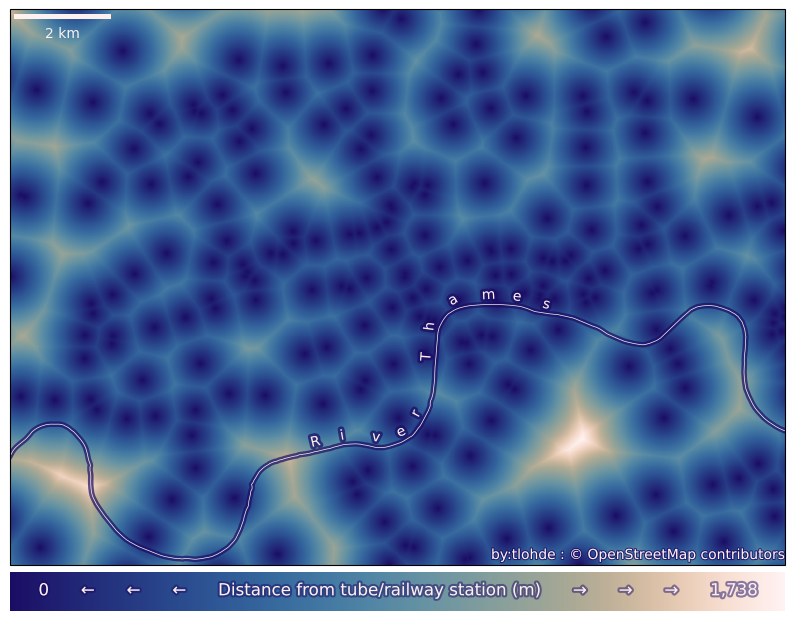

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.epsg(27700)}, figsize=[10,10])

# clip proximity surface to new bounds of zones 1/3 and  surface, and plot
proximity.rio.clip_box(minx, miny, maxx, maxy).plot(ax=ax,
                                                    add_colorbar=True,
                                                    vmin=0, vmax=1739,
                                                    cmap=cmc.lapaz,
                                                    cbar_kwargs={'orientation':'horizontal',
                                                                 'pad':0.01})

# plot river
ax.plot(*thames.coords.xy, c=cmc.lapaz(0.99), lw=0.5,
        path_effects=[path_effects.Stroke(linewidth=4, foreground=cmc.lapaz(0), alpha=0.7),
                      path_effects.Normal()]
        )

# river annotation
offset = thames.parallel_offset(50, side='left', resolution=64)
text_along_path('River Thames',
                LineString(
                    [offset.interpolate(i, normalized=True)
                     for i in np.arange(0.4, 0.7, 0.01)]),
                va='bottom',
                color=cmc.lapaz(0.99),
                path_effects=[path_effects.Stroke(linewidth=4, foreground=cmc.lapaz(0), alpha=0.7),
                              path_effects.Normal()],
                ax=ax)

# attribution
ax.annotate('by:tlohde : © OpenStreetMap contributors',
            xy=(1,0.01),
            ha='right',
            xycoords='axes fraction',
            color=cmc.lapaz(0.99),
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground=cmc.lapaz(0), alpha=0.8),
                          path_effects.Normal()],
            fontsize=10)

# scale bar
ax.add_artist(ScaleBar(1, location='upper left', frameon=False, box_alpha=0, color=cmc.lapaz(0.99)))

ax.set_title(None)

# colorbar styling / labelling
fig.get_axes()[-1].set_axis_off()
fig.get_axes()[-1].set_title('0      ←      ←      ←      Distance from tube/railway station (m)      →      →      →      1,738',
                             y=0.5,
                             va='top',
                             color=cmc.lapaz(0.99),
                             path_effects=[path_effects.Stroke(linewidth=3, foreground=cmc.lapaz(0), alpha=0.5),
                                           path_effects.Normal()])

fig.savefig('day6_2.png', dpi=300, bbox_inches='tight')